In [1]:
import sys
import os 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from glob import glob
import h5py

from PlittGiocomo_CA1Morph_2019 import morph_analyses
pp = morph_analyses.preprocessing
pc = morph_analyses.PlaceCellAnalysis
u = morph_analyses.utilities
b = morph_analyses.behavior
sm = morph_analyses.SimilarityMatrixAnalysis


%matplotlib inline
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'PlittGiocomo_CA1Morph_2019'

In [17]:
basedir = "E:\\"
mouse = '4467975.1'
date = '09_10_2020'
scene = 'TwoTower_foraging'
session = "004"
scannum = "011"
scan = "%s_%s_%s" % (scene,session,scannum)

int(session)

4

In [18]:
sess  = {'data file': os.path.join("G:\\My Drive\\VR_Data\\TwoTower",mouse,date,"%s_%d.sqlite" % (scene,int(session))),
         'scanmat':os.path.join("I:\\2P_Data",mouse,date,scene,"%s.mat" % scan),
         's2pfolder': os.path.join(basedir,mouse,date,scene,"%s" % scan,"suite2p")}

#VRDat - pandas array of VR variables aligned to imaging data
# F - Fluorescence-neuropil
# S - "spikes", deconvolved activity rate
# dFF - delta F/ F
VRDat, F, S, dFF = pp.load_scan_sess(sess,fneu_coeff=.7)
S[np.isnan(S)]=0
S/=np.percentile(S,99,axis=0)[np.newaxis,:]
# trial info - dictionary of useful info on each trial 
# tstart_inds - trial start indices for pulling trials from S/F/dFF
# teleport inds - teleport/trial end indices
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
# S_trial_mat - trials x position bins x neurons array of position binned activity rates
# occ_trial_mat - trials x posiitons occupancy map
# edges - position bin edges
# centers - position bin centers
S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,
                                                    VRDat['pos']._values,tstart_inds,
                                                    teleport_inds,bin_size=10,
                                                    speed = VRDat['speed']._values)

effMorph = trial_info['morphs']+trial_info['wallJitter']

num aberrant ttls 0.0
8.67344618494189 1881.6069984840829
8.73168266801415 1881.5159171298637


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


frame diff 0


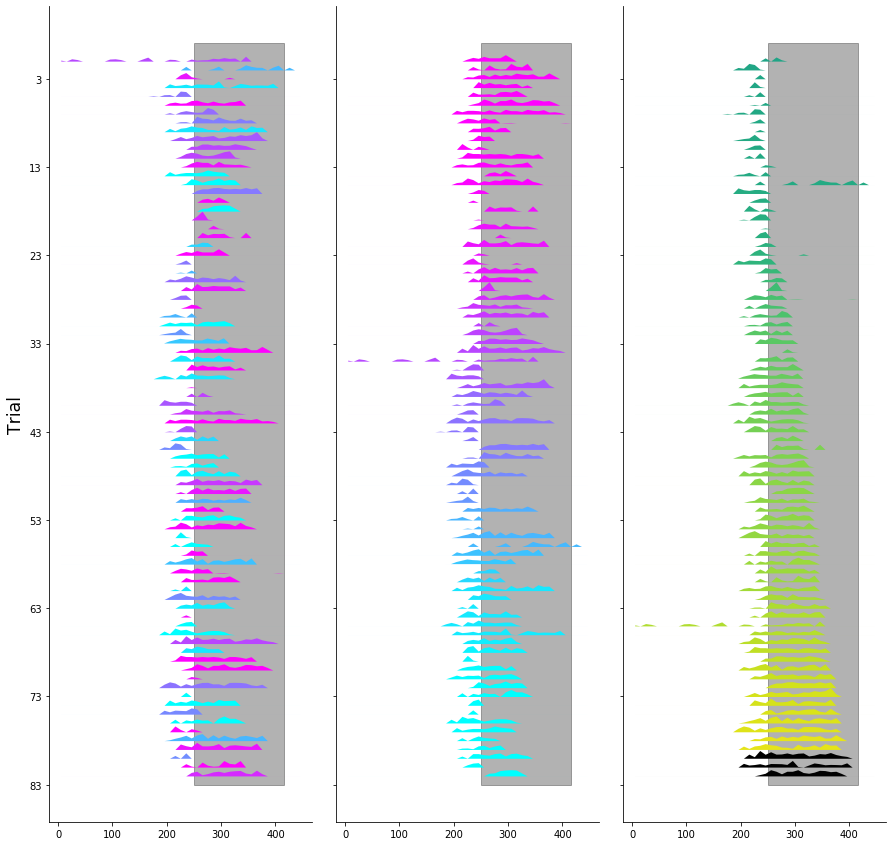

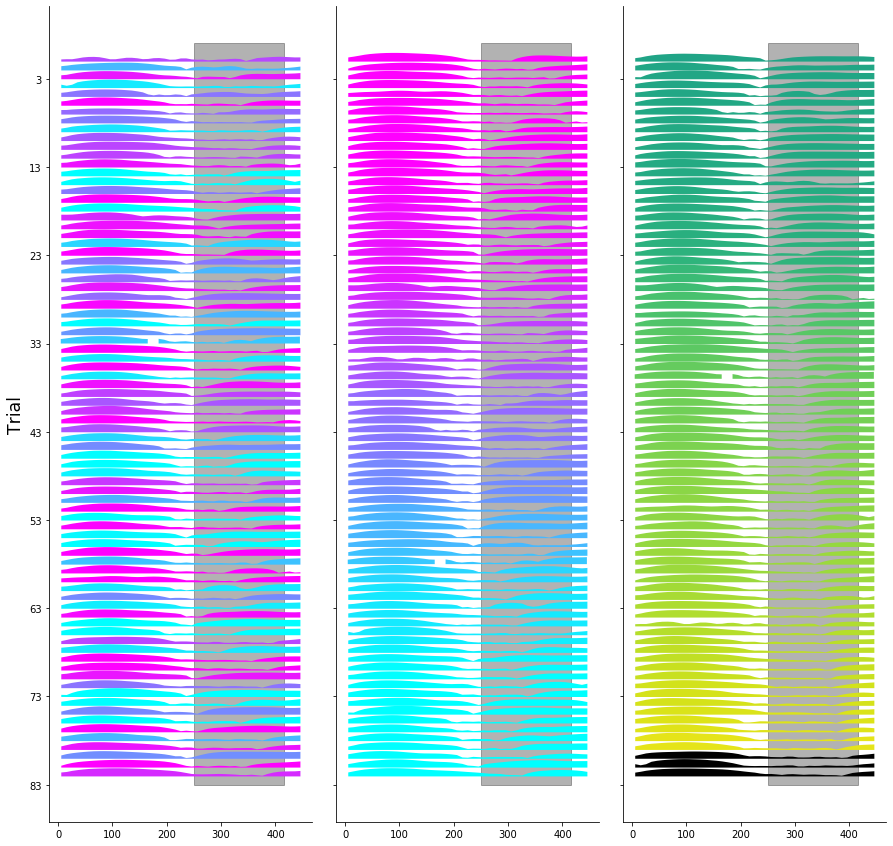

In [19]:
# licking and running behavior
effMorph = trial_info['morphs']+trial_info['wallJitter']
reward_pos = trial_info['rzone_entry']
reward_pos[np.isnan(reward_pos)]= 480

lick_trial_mat= u.make_pos_bin_trial_matrices(VRDat['lick']._values,
                                        VRDat['pos']._values,
                                        tstart_inds,
                                        teleport_inds,
                                        mat_only=True,bin_size=10)
# lick_morph_dict = u.trial_type_dict(lick_trial_mat,trial_info['morphs'])
max_pos = np.copy(trial_info['max_pos'])
max_pos[max_pos>440]=np.nan

# plot speed data
speed_trial_mat = u.make_pos_bin_trial_matrices(VRDat['speed']._values,
                                                VRDat['pos']._values,
                                                tstart_inds,
                                                teleport_inds,
                                                mat_only=True,bin_size=10)
# speed_morph_dict = u.trial_type_dict(speed_trial_mat,trial_info['morphs'])


f_lick, axarr_lick = b.behavior_raster_foraging(lick_trial_mat/np.nanmax(lick_trial_mat.ravel()),
                                                    centers,effMorph,reward_pos/390.,smooth=False)

f_speed,axarr_speed = b.behavior_raster_foraging(speed_trial_mat/np.nanmax(speed_trial_mat.ravel()),
                                                    centers,effMorph,reward_pos/390.,smooth=False)


In [20]:
# place cells
masks, FR, SI = pc.place_cells_calc(S, VRDat['pos']._values,trial_info,
                        tstart_inds, teleport_inds,
                        speed=VRDat.speed._values,
                        win_trial_perm=True,morphlist=np.unique(trial_info['morphs']).tolist())


perm 0


C:\Users\mplitt\repos\PlittGiocomo_CA1Morph_2019\morph_analyses\utilities.py:268: RuntimeWarning: Mean of empty slice
  trial_mat[trial,b] = np.nanmean(arr_t[(pos_t>edge1) & (pos_t<=edge2),:],axis=0)


morph 0 place cells = 354 out of 856 , 0.413551 
morph 1 place cells = 340 out of 856, 0.397196


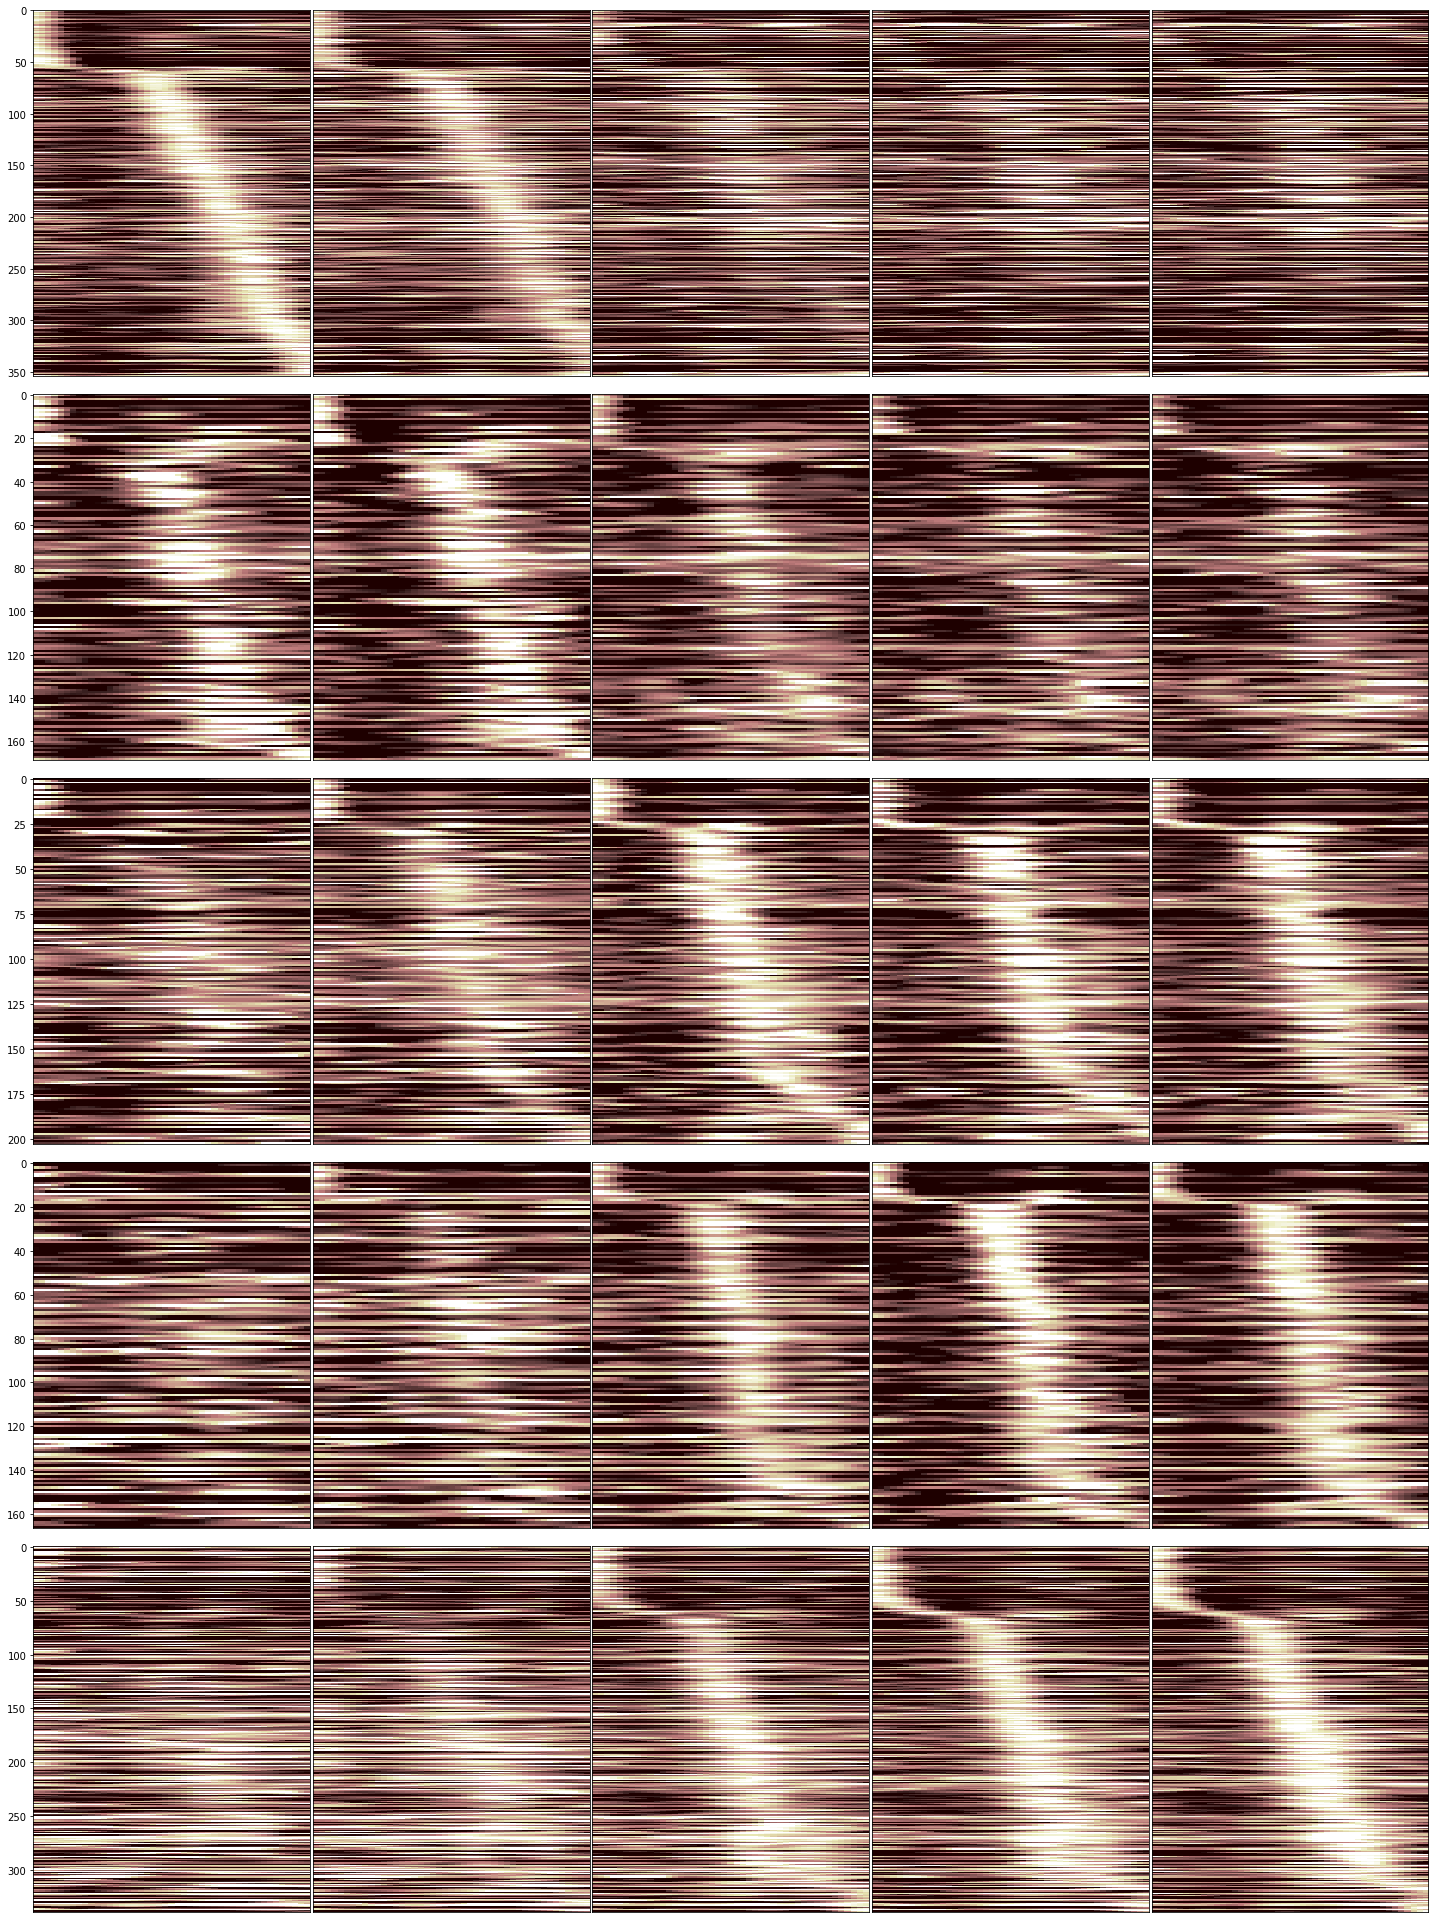

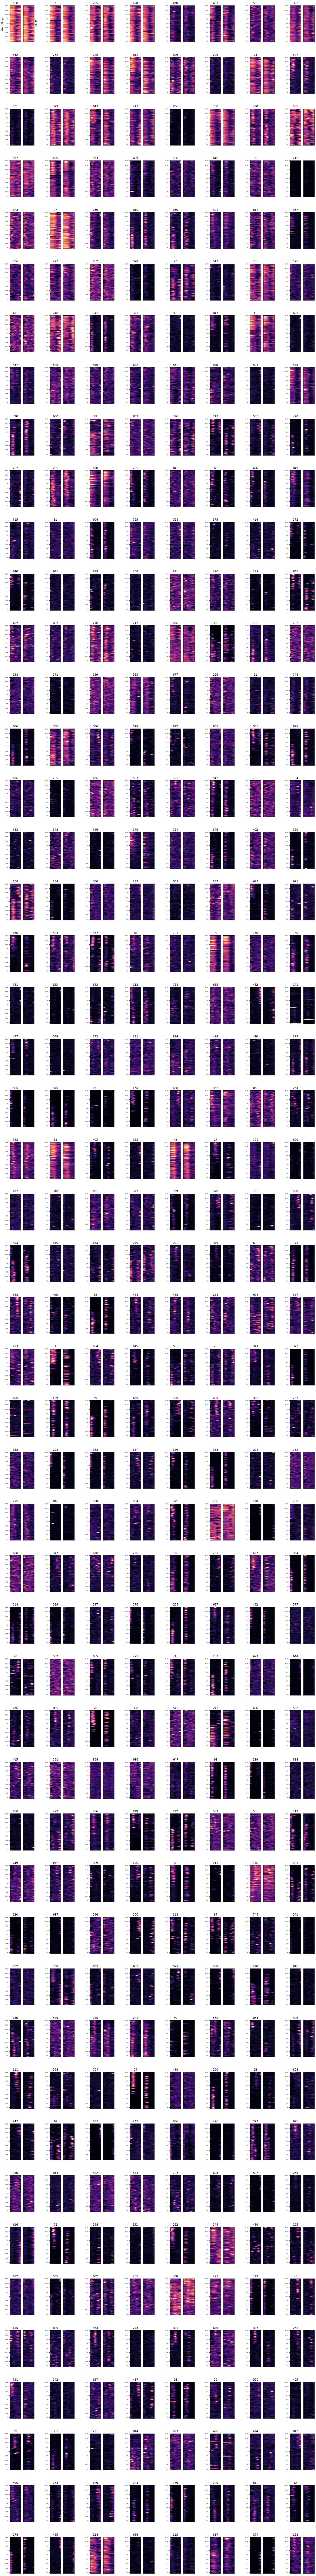

In [25]:
S_morph_dict = u.trial_type_dict(S_trial_mat,trial_info['morphs'])
# plot place cells by morph
f_pc, ax_pc,PC_dict = pc.plot_placecells(S_morph_dict,masks)
f_pc.savefig("G:\\My Drive\\STX3_results\\scratch\\4467975.1_sess3_placecells.png")
# number in each environment
print('morph 0 place cells = %g out of %g , %f ' % (masks[0].sum(), masks[0].shape[0], masks[0].sum()/masks[0].shape[0]))
print('morph 1 place cells = %g out of %g, %f' % (masks[1].sum(), masks[1].shape[0], masks[1].sum()/masks[1].shape[0]))

# single cell plots
f_singlecells = pc.plot_top_cells(S_trial_mat,masks,SI,effMorph)


0
38.8394669782528
26.985939559469823
16.630425283123486
12.768177653294616
13.323318918787061
10.135084123441366
11.12107646014125
11.102323986884196


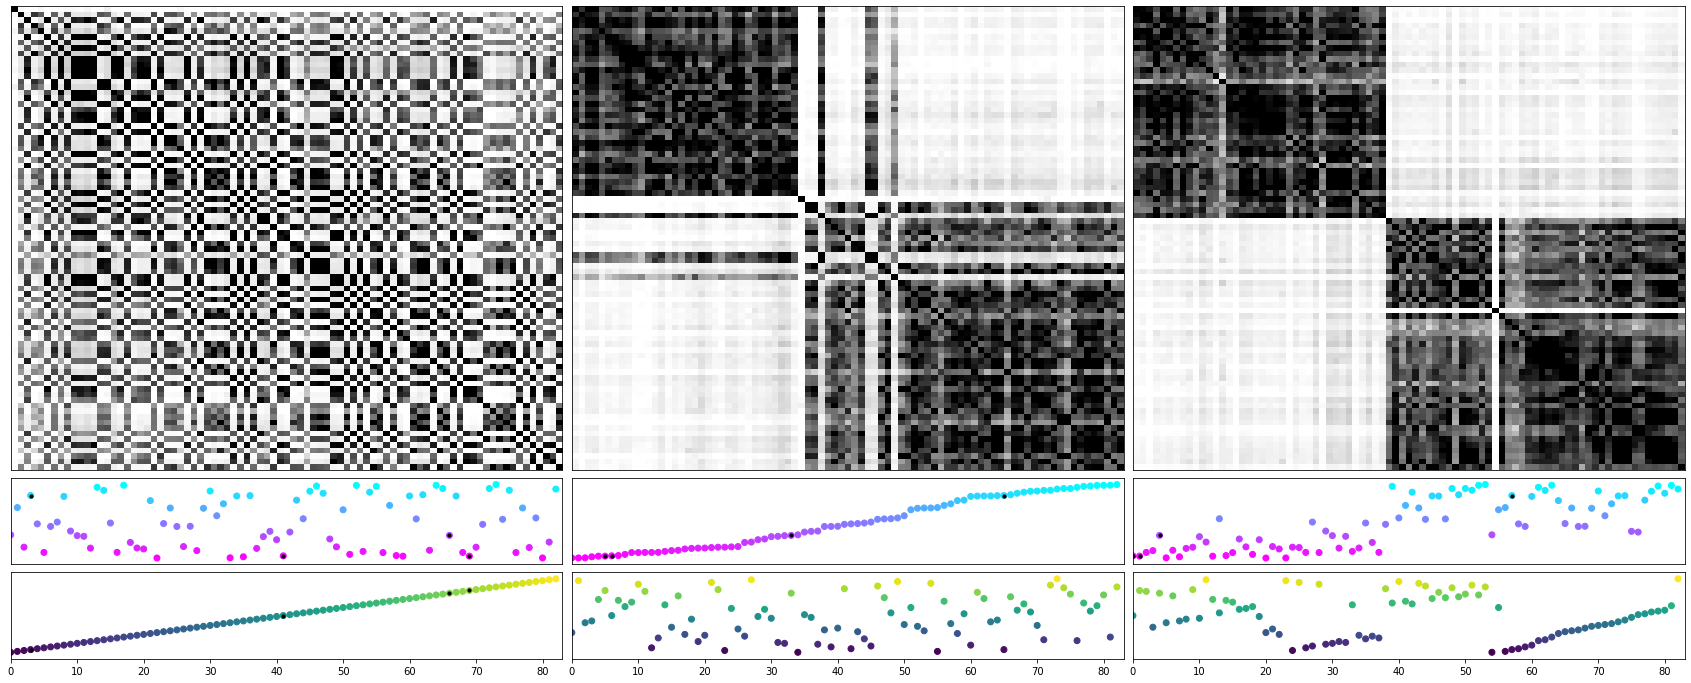

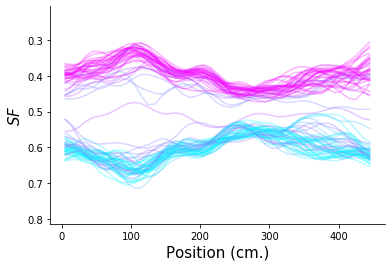

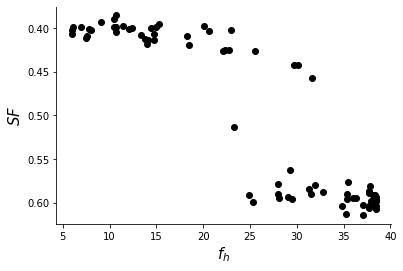

In [24]:
# trial x trial similarity matrix
S_trial_mat[np.isnan(S_trial_mat)]=0.
# S_trial_mat is trials x positions x neurons
S_trial_mat = sp.ndimage.filters.gaussian_filter1d(S_trial_mat,1,axis=1) # smooth position by 1 bin

#flatten to be trial x positions*neurons
S_tmat = np.reshape(S_trial_mat,[S_trial_mat.shape[0],-1])
# divide trials by l2-norm
S_tmat = S_tmat/np.linalg.norm(S_tmat,ord=2,axis=-1)[:,np.newaxis]
# outer product give trial x trial cosine similarity
S_t_rmat = np.matmul(S_tmat,S_tmat.T)
print((S_t_rmat<0).sum())
f_stsm,axtup_stsm = sm.plot_trial_simmat(S_t_rmat,trial_info)
f_stsm.savefig("G:\\My Drive\\STX3_results\\scratch\\4467975.1_sess3_simmat.png")

# similarity fraction vs position
rtsf = u.rt_similarity_fraction(S_trial_mat,trial_info,sigma=0)
f, rtsf_ax = plt.subplots()
for t in range(rtsf.shape[0]):
    rtsf_ax.plot(np.arange(5,450,10),rtsf[t,:],alpha=.3,c=plt.cm.cool(1-effMorph[t]))
            
rtsf_ax.spines['top'].set_visible(False)
rtsf_ax.spines['right'].set_visible(False)
rtsf_ax.set_ylim([np.nanmax(rtsf.ravel())+.1,np.nanmin(rtsf.ravel())-.1])
rtsf_ax.set_xlabel("Position (cm.)",fontsize=15)
rtsf_ax.set_ylabel("$SF$",fontsize=15)
f.savefig("G:\\My Drive\\STX3_results\\scratch\\4467975.1_sess3_rtsf.png")

# summary similarity fraction
sf = u.similarity_fraction(S_trial_mat,trial_info)
f, sf_ax = plt.subplots()
sf_ax.scatter(morph_analyses.UnityTransforms.xfreq(effMorph),sf,color='black') #,c=plt.cm.cool(1-effMorph))
sf_ax.set_ylim([np.nanmax(sf)+.01,np.nanmin(sf)-.01])
sf_ax.spines['top'].set_visible(False)
sf_ax.spines['right'].set_visible(False)
sf_ax.set_xlabel("$f_h$",fontsize=15)
sf_ax.set_ylabel("$SF$",fontsize=15)
f.savefig("G:\\My Drive\\STX3_results\\scratch\\4467975.1_sess3_sf.png")